In [1]:
# imports, initalize output path as none 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tkinter import Tk, filedialog
output_path = None

In [2]:
def screen_data(df, features, target): # data screening function
    """
    Creates a subset of the desired features and applies listwise deletion (deletes rows if any feature is missing).
    
    Parameters:
        df (DataFrame): Original DataFrame.
        features (list): List of feature column names to retain.
        target (str): optional one off parameter.
    
    Returns:
        subset (DataFrame): Processed DataFrame after listwise deletion.
    """
    if target is not None:
        subset = df[features + [target]].dropna(axis=0, how='any')
    else:
        subset = df[features].dropna(axis=0, how='any')
        
    
    if subset.empty:
        print(f"Dataset is empty.")
        return None,

    return subset

In [3]:
def get_marker_map(subset, target):
    """
    Generate a mapping from unique categorical values to specific marker types for plotting.

    This function ensures that the dataset has exactly three unique values in the specified target column
    and maps each unique value to a distinct marker type.

    Parameters:
        subset (pandas.DataFrame): The subset of the dataset to be used for the mapping.
        target (str): The column name in the dataset whose unique values will be mapped to markers.

    Returns:
        dict: A dictionary where keys are the unique values from the target column and values are marker strings.
    
    Raises:
        ValueError: If the target column does not have exactly three unique values.

    Example:
        subset
        3-tier rank  feature1
        0           A        1.0
        1           B        2.0
        2           C        3.0
        3           A        4.0
        4           B        5.0
        target = '3-tier rank'
        get_marker_map(subset, target)
        {'A': 'o', 'B': 's', 'C': '^'}
    """
    # Check that there are exactly three unique '3-tier rank' values
    unique_rates = subset[target].unique()
    assert len(unique_rates) == 3, "The dataset must have exactly 3 unique '3-tier rank' values"

    # Define a list of markers for the three unique degradation rates
    markers = ['o', 's', '^']
    marker_map = {rate: markers[i] for i, rate in enumerate(unique_rates)}
    return marker_map

In [4]:
def select_output_directory():# Get the output directory from user input
    """
    This function prompts the user to select an output directory using a graphical file dialog.

    Returns:
        str: The path of the selected output directory.

    Raises:
        Exception: If no directory is selected by the user.
    """
    # Initialize the Tkinter root window
    root = Tk()

    # Lift the root window to the top
    root.lift()
    root.attributes('-topmost', True)
    
    # Open a directory selection dialog and store the selected directory
    directory = filedialog.askdirectory(title="Select Output Directory", parent=root)

    # Withdraw the root window after the dialog is closed
    root.withdraw()

    # Check if a directory was selected
    if directory:
        return directory
    else:
        raise Exception("No directory selected.")  

In [5]:
def save_location_pre_processing_folder(output_path):
    """
    Prepares the output directory and file for correlation significance results.

    Parameters:
        output_path (str, optional): The base directory where results will be saved. Defaults to None.

    Returns:
        tuple: A tuple containing the output directory path and the output file path.
    """
    # create output path and file 
    if output_path is None:
        output_path = select_output_directory()
        output_path = f"{output_path}/linear_separability_plots"

    return output_path

In [6]:

# data set loading, feature definitions,alpha for significance test

# Load the Excel file
df = pd.read_excel('..\Project Dataset.xlsx', sheet_name='data', engine='openpyxl')

# defining the desired weight loss reporting methods for screening
wtlossreporting= [['BOD (% /day)','BOD'], ['wt. loss (% /day)','WT LOSS']]
         
# defining significance level 
alpha = 0.1

# renaming features for clarity
df = df.rename(columns={'BOD (% day-1)': 'BOD (% /day)',
                        'wt. loss (% day-1)':'wt. loss (% /day)',                        
                        'den (g mL-1)':'den (g/mL)',
                        "% cryst": "% crystallinity", 
                        "enthalpy (J g-1)": "enthalpy (J/g)", 
                        "LogP(SA)-1 (Å-2)": "LogP/(SA)", 
                        "Mw (kg mol-1)": "Mw (kg/mol)",
                        "Mn (kg mol-1)": "Mn (kg/mol)",
                        '3-tier rank': 'Degradation Rate'
                        })

# grouping feature for plots
target = 'Degradation Rate'

# defining the subset features
features = ['den (g/mL)', 
            'total sp3 C', 
            '% sp3 C', 
            'LogP/(SA)',
            'Mw (kg/mol)', 
            'Mn (kg/mol)', 
            'Mw/Mn',
            'Tg (°C)', 
            'Tm (°C)', 
            '% crystallinity', 
            'enthalpy (J/g)', 
            '(Tw-Tg)/(LogP/SA)', 
            ]

# cant use special characters in the save files so now it maps to an acceptable name
save_name_mapping = {'den (g/mL)':'density',
                    'total sp3 C':'total sp3 C', 
                    '% sp3 C':'percent sp3 C', 
                    'LogP/(SA)': 'LogPSA',
                    'Mw (kg/mol)': 'MW', 
                    'Mn (kg/mol)': 'Mn', 
                    'Mw/Mn':'Ratio MwMn',
                    'Tg (°C)':'Tg',
                    'Tm (°C)':'Tm',
                    '% crystallinity':'percent crystallinity',
                    'enthalpy (J/g)':'enthalpy',
                    '(Tw-Tg)/(LogP/SA)':'TWTW_LogPSA'
                    }


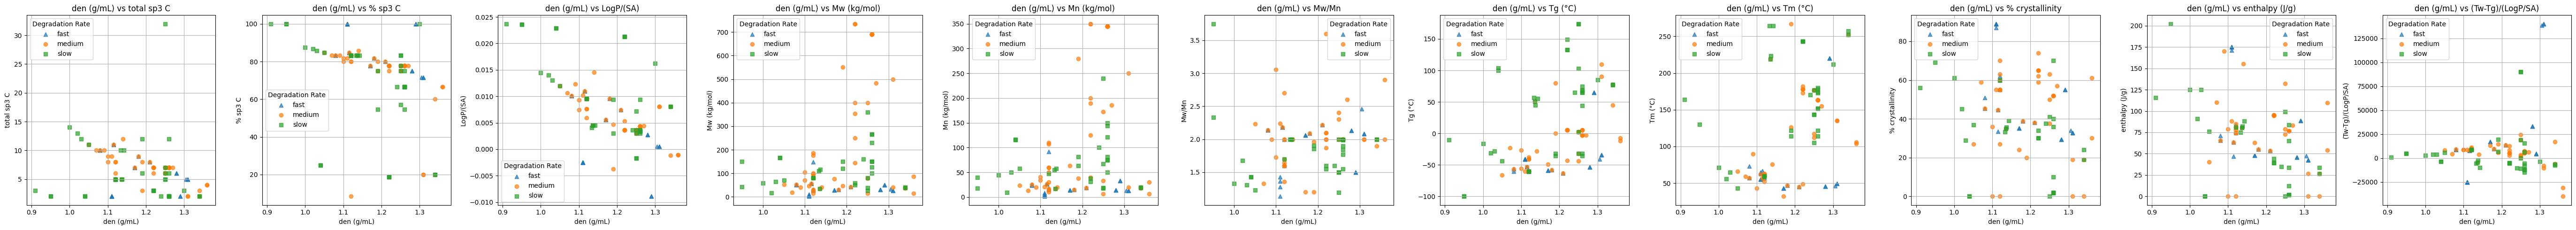

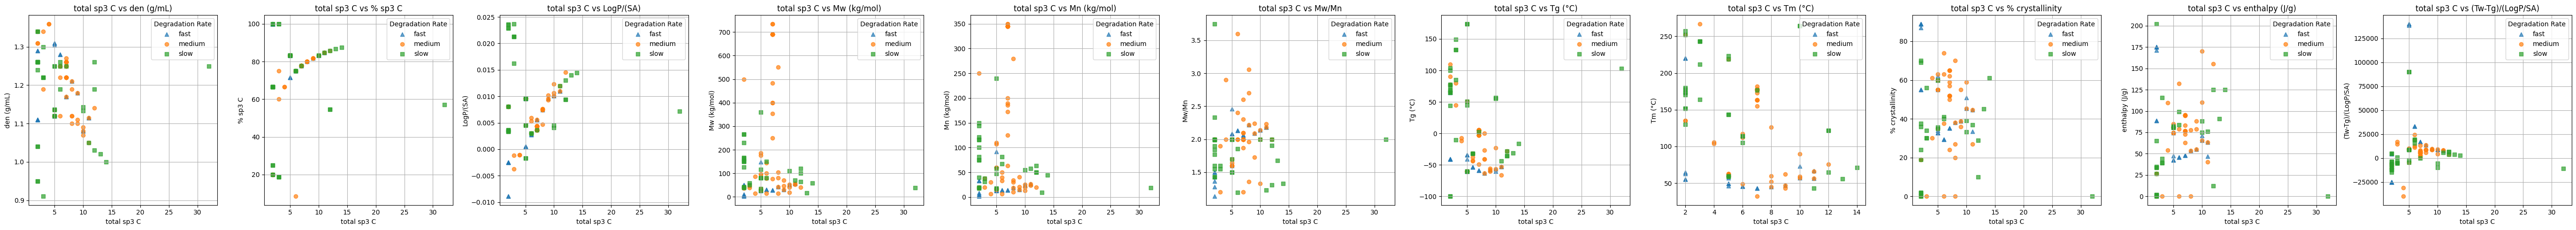

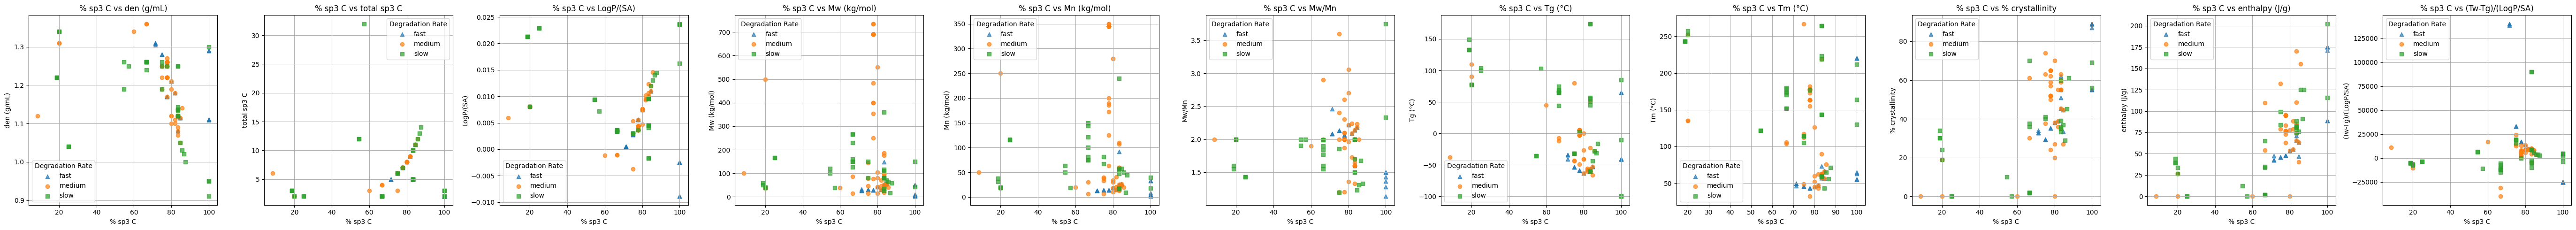

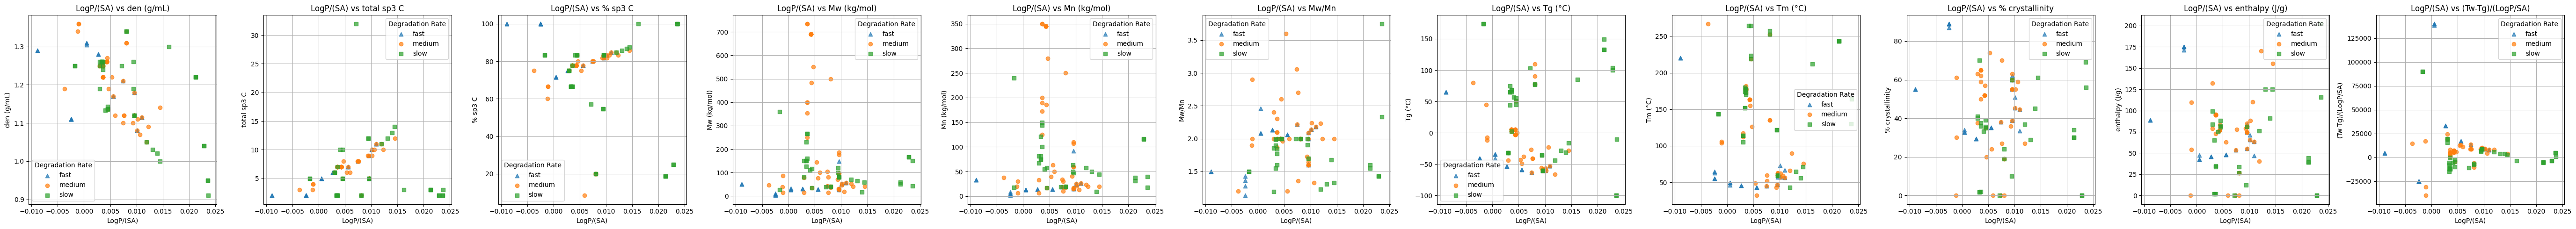

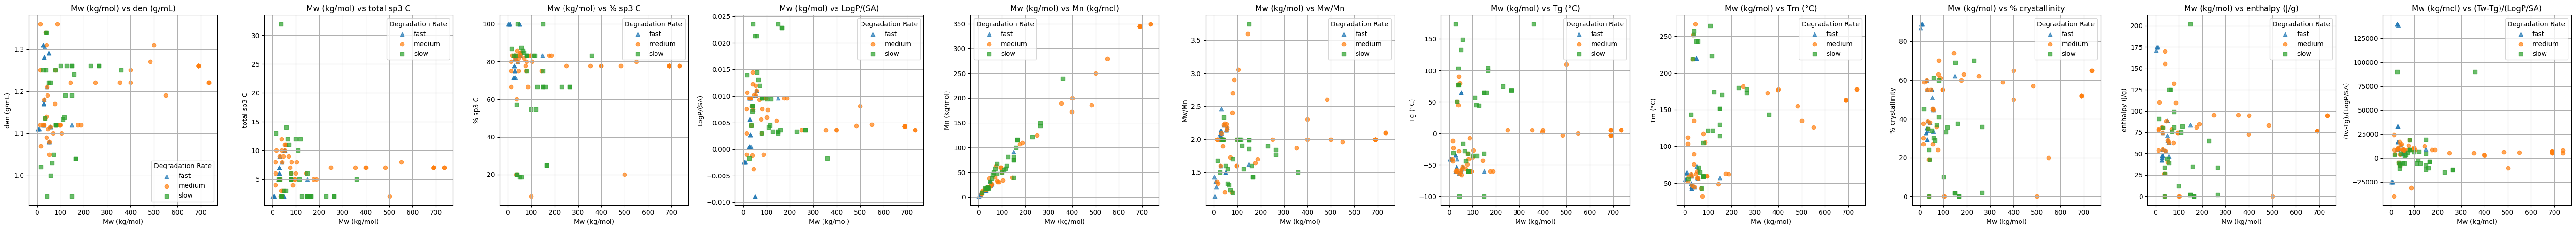

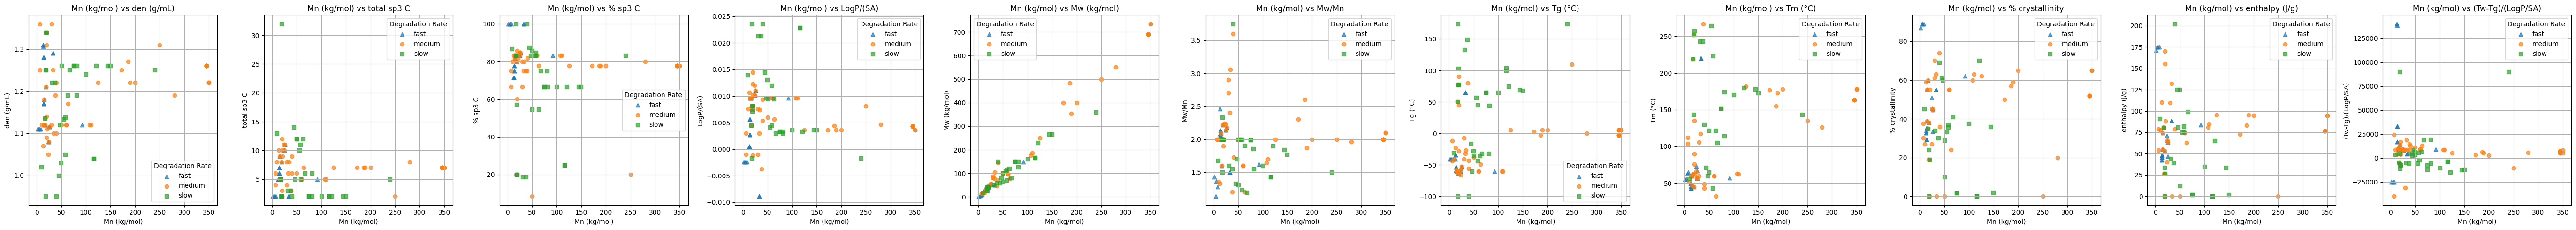

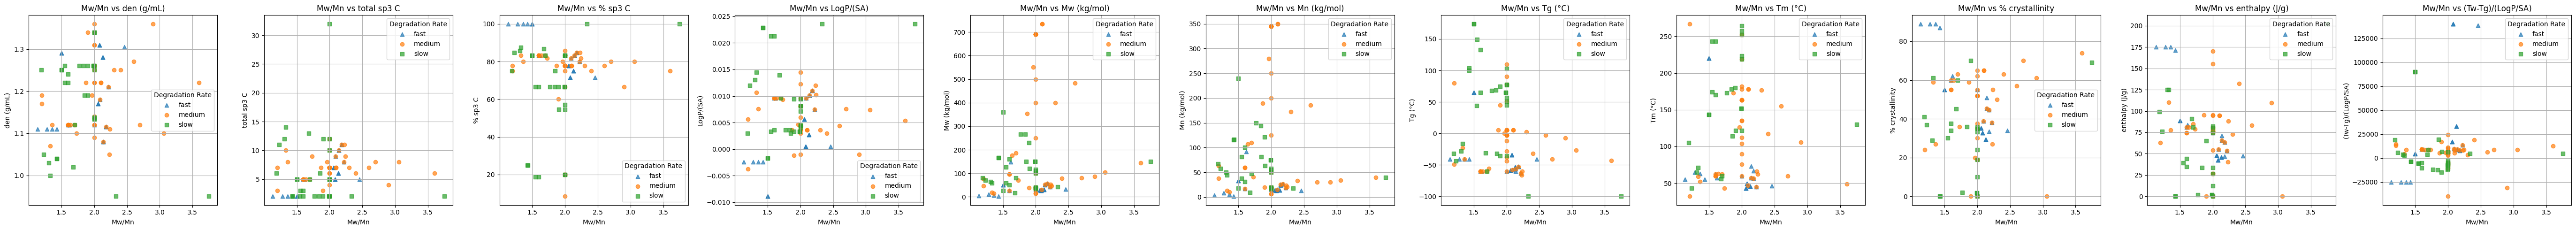

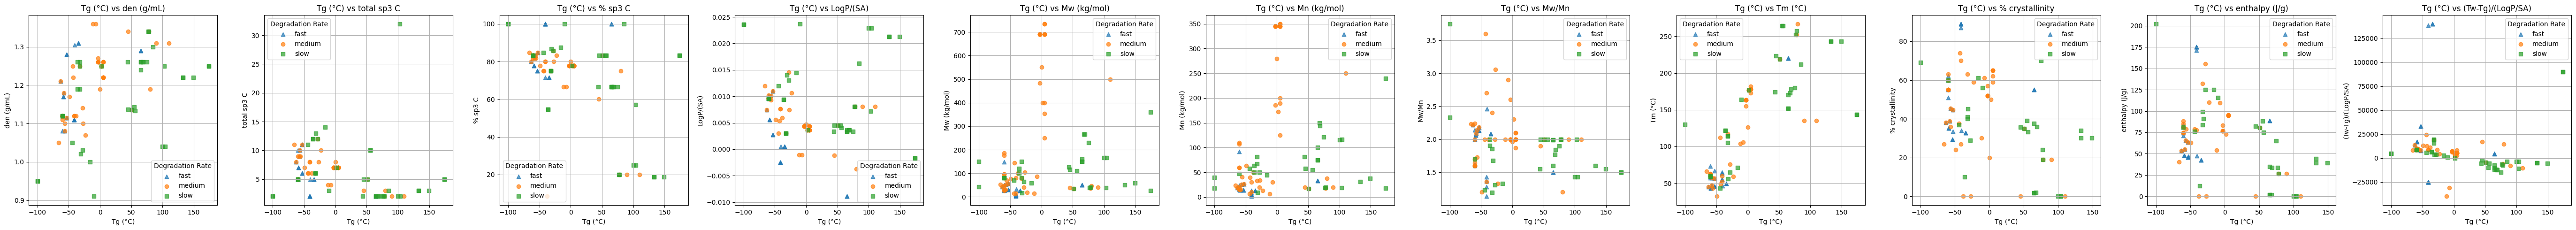

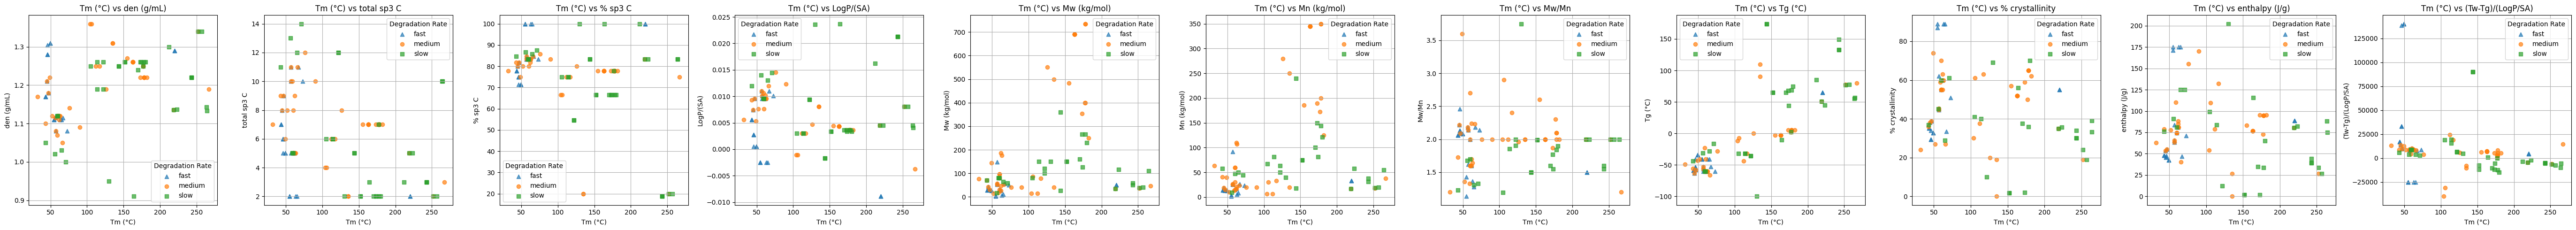

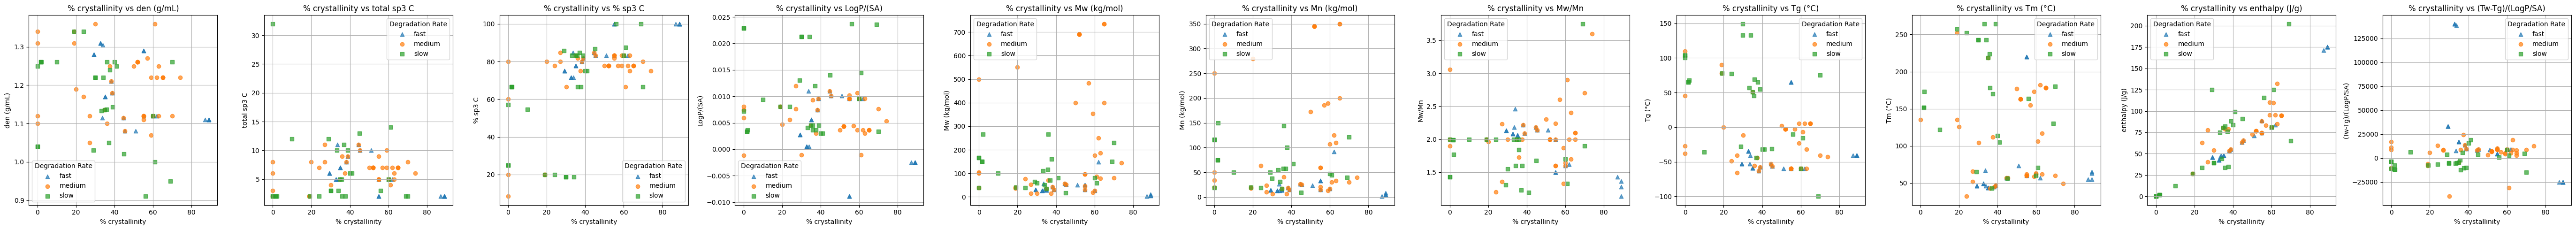

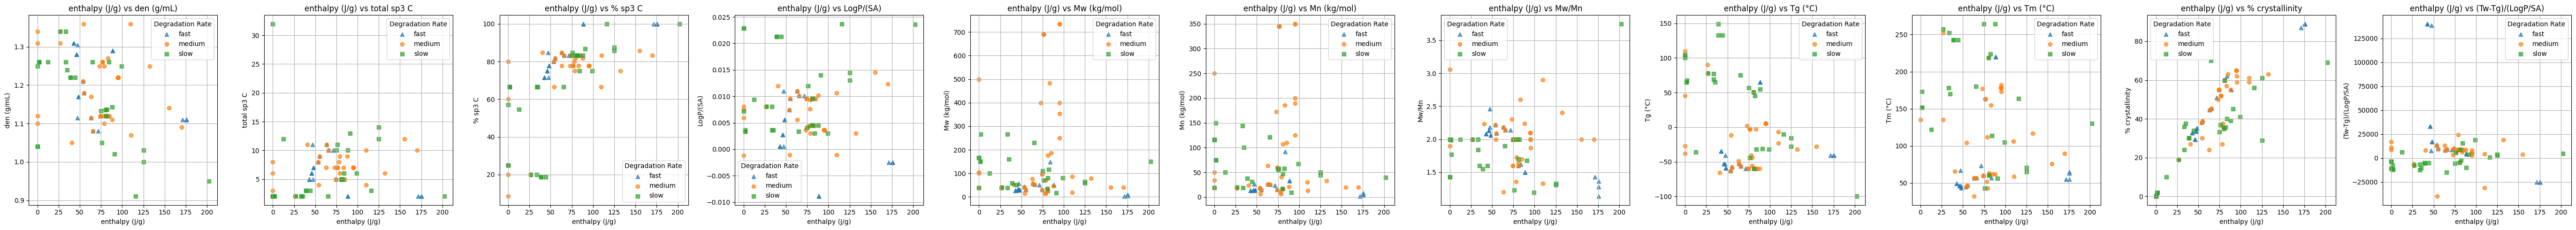

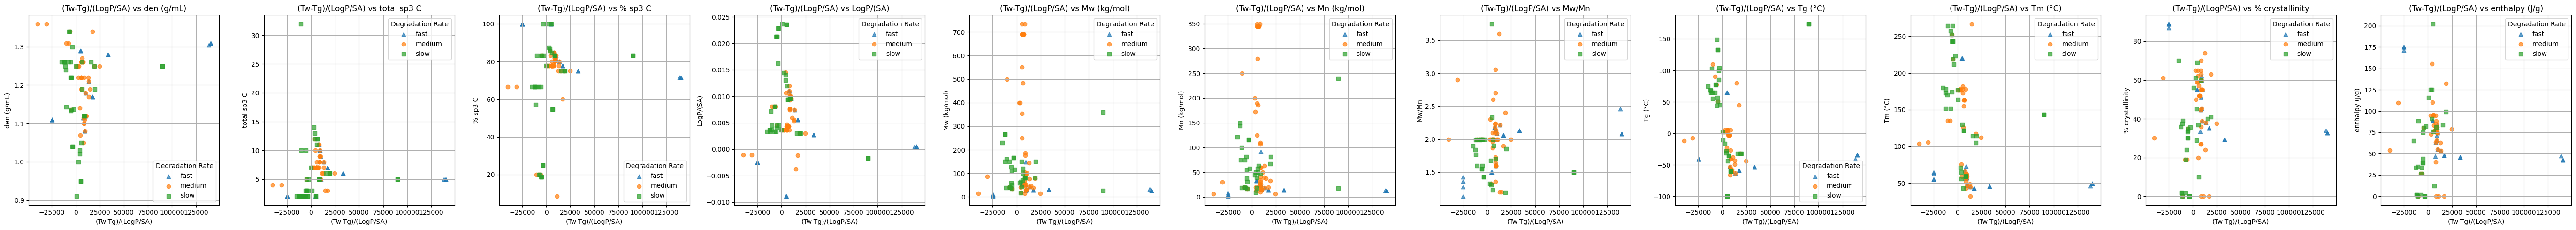

In [ ]:
output_path = save_location_pre_processing_folder(output_path) # geting output path from user input

data = screen_data(df, features, target) # data screening
marker_map = get_marker_map(data, target) # creating markers for plotting degradation rate

data_features = data[features] # removing 3 tier rank

num_features = data_features.shape[1] # getting the number of features to loop through 
# Determine the number of plots for the current x_axis
num_cols = num_features - 1
num_rows = 1  # Since we want to plot in a single row for each x_axis
    
# nested for loop for plotting
for i in range(num_features):
    x_axis = data_features.columns[i]
    
    
    # Create subplots for the current x_axis
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5))
    axes = axes.flatten() if num_cols > 1 else [axes]
    
    plot_index = 0
    
    for j in range(num_features):
        y_axis = data_features.columns[j]
        
        if y_axis == x_axis:
            continue
        
        ax = axes[plot_index]
        for rate, group in df.groupby(target):
            marker = marker_map[rate]
            ax.scatter(group[x_axis], group[y_axis], label=rate, marker=marker, alpha=0.7)
            
        ax.set_title(f"{x_axis} vs {y_axis}")
        ax.set_xlabel(x_axis)
        ax.set_ylabel(y_axis)
        ax.legend(title=target)
        ax.grid(True)
        
        plot_index += 1
    
    # Applying tight layout and showing the plot
    plt.tight_layout()
    
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    
    # Save the figure to the specified folder
    save_name = save_name_mapping[x_axis]
    plt.savefig(os.path.join(output_path, f"linear_separability_plot_{save_name}_vs_features.png"))
    plt.show()      
print("All plots have been saved")